In [17]:
import numpy as np
from scipy.optimize import minimize
from qulacs import QuantumCircuit as QulacsCircuit
from qulacs import QuantumState
from qulacs.gate import RX, RZ, CNOT
import json
from qiskit.circuit.library import RXGate, RZGate
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

class LineEntanglingLayerBuilder:
    """
    Build entangling layers according to the line topology.
    The 1st qubit will entangle with the 2nd, 2nd with 3rd, and so on.
    """
    def __init__(self, n_qubits: int):
        """Entangler according to the line topology.
        Args:
            n_qubits: number of qubits in the circuit.
        """
        self.n_qubits = n_qubits
        self.adjacency_matrix = np.zeros((n_qubits, n_qubits), dtype=np.int8)
        for i in range(n_qubits - 1):
            self.adjacency_matrix[i][i + 1] = self.adjacency_matrix[i + 1][i] = 1

    def build_layer(self, params):
        """Builds the entangling layer with the given parameters."""
        layer = []
        param_idx = 0
        for i in range(self.n_qubits - 1):
            layer.append((params[param_idx], i, i + 1))
            param_idx += 1
        return layer

class EntanglingLayerAnsatz:
    def __init__(self, n_qubits: int, n_layers: int, entangling_layer_builder: LineEntanglingLayerBuilder):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.entangling_layer_builder = entangling_layer_builder

    @property
    def number_of_params(self) -> int:
        return 2 * self.n_qubits * self.n_layers + (self.n_qubits - 1) * self.n_layers

    @property
    def number_of_qubits(self) -> int:
        return self.n_qubits

    def get_executable_circuit(self, params):
        circuit = QuantumCircuit(self.n_qubits)
        param_idx = 0
        for layer_idx in range(self.n_layers):
            # Apply RX and RZ gates
            for qubit in range(self.n_qubits):
                circuit.append(RXGate(params[param_idx]), [qubit])
                param_idx += 1
                circuit.append(RZGate(params[param_idx]), [qubit])
                param_idx += 1
            # Apply entangling layer
            entangling_layer = self.entangling_layer_builder.build_layer(params[param_idx:])
            for theta, qubit1, qubit2 in entangling_layer:
                circuit.cx(qubit1, qubit2)
                circuit.rz(2 * theta, qubit2)
                circuit.cx(qubit1, qubit2)
            param_idx += self.n_qubits - 1
        return circuit

    def draw_circuit(self):
        params = [Parameter(f'theta_{i}') for i in range(self.number_of_params)]
        circuit = self.get_executable_circuit(params)
        return circuit.draw(output='mpl')

class ScipyOptimizer:
    def __init__(self, method='Powell', options=None):
        self.method = method
        self.options = options if options else {}

    def minimize(self, loss_fn, initial_params):
        result = minimize(loss_fn, initial_params, method=self.method, options=self.options)
        return result

class SingleBasisQCBM:
    def __init__(self, ansatz, optimizer, distance_measure=None, choices=(-1.0, 1.0), param_initializer=None):
        self.ansatz = ansatz
        self.optimizer = optimizer
        self.num_qubits = ansatz.number_of_qubits
        self.distance_measure = distance_measure if distance_measure else self._default_distance_measure
        self.choices = choices
        self.params = self._get_initial_parameters(param_initializer)

    def _default_distance_measure(self, target_probs, model_probs):
        epsilon = 1e-10
        return np.sum(target_probs * np.log(target_probs / (model_probs + epsilon) + epsilon))

    def _get_initial_parameters(self, initializer):
        if initializer:
            return initializer(self.ansatz.number_of_params)
        return np.random.uniform(-np.pi / 2, np.pi / 2, self.ansatz.number_of_params)

    def _get_model_object(self, parameters):
        circuit = QulacsCircuit(self.num_qubits)
        param_idx = 0
        for layer_idx in range(self.ansatz.n_layers):
            # Apply RX and RZ gates
            for qubit in range(self.num_qubits):
                circuit.add_RX_gate(qubit, parameters[param_idx])
                param_idx += 1
                circuit.add_RZ_gate(qubit, parameters[param_idx])
                param_idx += 1
            # Apply entangling layer
            entangling_layer = self.ansatz.entangling_layer_builder.build_layer(parameters[param_idx:])
            for theta, qubit1, qubit2 in entangling_layer:
                circuit.add_CNOT_gate(qubit1, qubit2)
                circuit.add_RZ_gate(qubit2, 2 * theta)
                circuit.add_CNOT_gate(qubit1, qubit2)
            param_idx += self.num_qubits - 1

        state = QuantumState(self.num_qubits)
        circuit.update_quantum_state(state)
        probs = np.abs(state.get_vector())**2
        return probs

    def _get_generator_fn(self, random_seed=None):
        def generator(n_samples, parameters):
            circuit = QulacsCircuit(self.num_qubits)
            param_idx = 0
            for layer_idx in range(self.ansatz.n_layers):
                # Apply RX and RZ gates
                for qubit in range(self.num_qubits):
                    circuit.add_RX_gate(qubit, parameters[param_idx])
                    param_idx += 1
                    circuit.add_RZ_gate(qubit, parameters[param_idx])
                    param_idx += 1
                # Apply entangling layer
                entangling_layer = self.ansatz.entangling_layer_builder.build_layer(parameters[param_idx:])
                for theta, qubit1, qubit2 in entangling_layer:
                    circuit.add_CNOT_gate(qubit1, qubit2)
                    circuit.add_RZ_gate(qubit2, 2 * theta)
                    circuit.add_CNOT_gate(qubit1, qubit2)
                param_idx += self.num_qubits - 1

            state = QuantumState(self.num_qubits)
            circuit.update_quantum_state(state)
            samples = np.random.choice(2**self.num_qubits, n_samples, p=np.abs(state.get_vector())**2)
            samples = np.array([list(map(int, np.binary_repr(s, self.num_qubits))) for s in samples])
            return samples
        return generator

    def train_on_batch(self, X, Y, n_epochs):
        target_probs = np.zeros(2**self.num_qubits)
        for x, y in zip(X, Y):
            index = int("".join(map(str, x)), 2)
            target_probs[index] = y
        loss_values= []
        for epoch in range(n_epochs):
            def loss_fn(parameters):
                model_probs = self._get_model_object(parameters)
                return self.distance_measure(target_probs, model_probs)

            result = self.optimizer.minimize(loss_fn, self.params)            
            self.params = result.x
            loss_values.append(loss_fn(self.params))
        return result,loss_values

    def generate(self, num_samples):
        generator = self._get_generator_fn()
        samples = generator(num_samples, self.params)
        unique_samples, counts = np.unique(samples, axis=0, return_counts=True)
        probabilities = counts / num_samples
        return unique_samples, probabilities

    def save_params(self, filename):
        with open(filename, 'w') as f:
            json.dump(self.params.tolist(), f)

    def load_params(self, filename):
        with open(filename, 'r') as f:
            self.params = np.array(json.load(f))

# Define an example of creating and training a SingleBasisQCBM

num_qubits = 4
depth = 3
X = np.array([[1, 1, 1,1], [0, 1, 0,0],[0, 1, 1,0], [0, 0, 0,0], [0, 0, 1,0]])
Y = np.array([0.2, 0.2,0.2,0.2,0.2])

entangling_layer_builder = LineEntanglingLayerBuilder(num_qubits)
ansatz = EntanglingLayerAnsatz(num_qubits, depth, entangling_layer_builder)

options = {
    'maxiter': 500,   # Maximum number of iterations
    'tol': 1e-6,      # Tolerance for termination
    'disp': True      # Display convergence messages
}

optimizer = ScipyOptimizer(method='Powell', options=options)

qcbm = SingleBasisQCBM(ansatz, optimizer)

n_epochs = 10

result,loss_values = qcbm.train_on_batch(X, Y, n_epochs)
num_samples = 1000
unique_samples, probabilities = qcbm.generate(num_samples)
for sample, prob in zip(unique_samples, probabilities):
    print(f"Sample: {sample}, Probability: {prob}")

# Save the QCBM parameters to a file
qcbm.save_params('qcbm_params.json')

    # Draw the QCBM circuit with symbolic parameters
   


/var/folders/01/9cxlhzln35j3j4d6wdv8jmmw0000gp/T/ipykernel_51296/3709815445.py:79: OptimizeWarning: Unknown solver options: tol
  result = minimize(loss_fn, initial_params, method=self.method, options=self.options)


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 15242
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 907
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 900
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 969
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 937
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 1001
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 1001
Optimization terminate

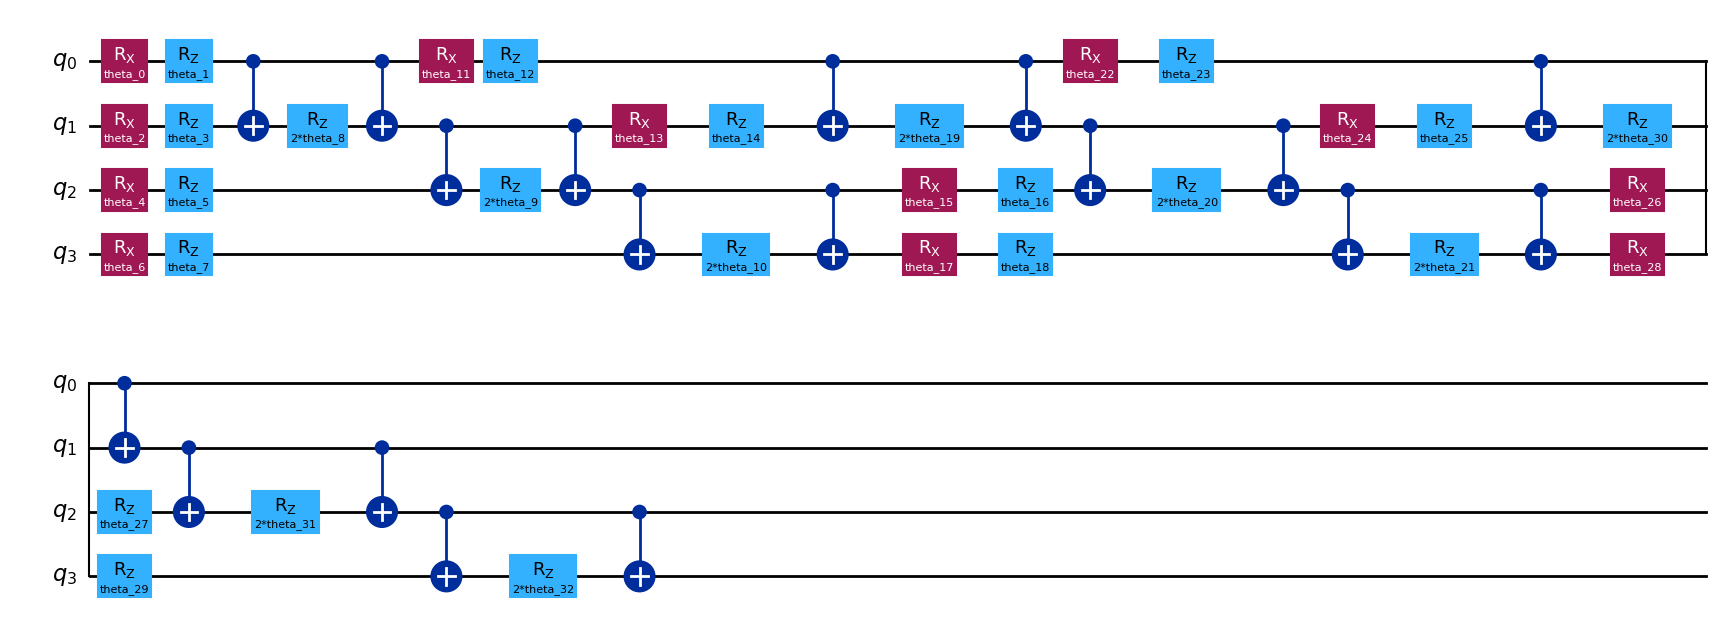

In [14]:

ansatz.draw_circuit()


In [15]:
unique_samples

array([[0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 1, 0],
       [1, 1, 1, 1]])

In [16]:
probabilities

array([0.186, 0.182, 0.217, 0.221, 0.194])

In [82]:
import numpy as np
from itertools import combinations
import random

def generate_data(num_qubits, cardinality, num_samples):
    # Generate all possible binary vectors of length num_qubits with the given cardinality
    vectors = list(combinations(range(num_qubits), cardinality))
    
    # Convert combinations to binary vectors
    X = []
    for vec in vectors:
        binary_vec = [0] * num_qubits
        for idx in vec:
            binary_vec[idx] = 1
        X.append(binary_vec)
    
    # If the number of samples is less than the number of possible vectors, randomly sample
    if num_samples < len(X):
        X = random.sample(X, num_samples)
    
    # Generate random probabilities for each binary vector
    Y = np.random.uniform(0, 1, len(X))
    
    # Normalize probabilities to sum to 1
    Y = Y / np.sum(Y)
    
    return np.array(X), Y

num_qubits = 10
cardinality = 5
num_samples = 500

X, Y = generate_data(num_qubits, cardinality, num_samples)

# Print some examples of the generated data
print("Example X:", X[:5])
print("Example Y:", Y[:5])

Example X: [[1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 0 1 0 0 0 0]
 [1 1 1 1 0 0 1 0 0 0]
 [1 1 1 1 0 0 0 1 0 0]
 [1 1 1 1 0 0 0 0 1 0]]
Example Y: [0.00416484 0.00216015 0.00524269 0.00114342 0.0074836 ]


In [83]:
# Define an example of creating and training a SingleBasisQCBM

depth = 3
entangling_layer_builder = LineEntanglingLayerBuilder(num_qubits)
ansatz = EntanglingLayerAnsatz(num_qubits, depth, entangling_layer_builder)

options = {
    'maxiter': 200,   # Maximum number of iterations
    'tol': 1e-8,      # Tolerance for termination
    'disp': True      # Display convergence messages
}

optimizer = ScipyOptimizer(method='Powell', options=options)

qcbm = SingleBasisQCBM(ansatz, optimizer)

n_epochs = 10

result,loss_values = qcbm.train_on_batch(X, Y, n_epochs)
num_samples = 1000
unique_samples, probabilities = qcbm.generate(num_samples)
for sample, prob in zip(unique_samples, probabilities):
    print(f"Sample: {sample}, Probability: {prob}")

# Save the QCBM parameters to a file
qcbm.save_params('qcbm_params.json')


/var/folders/01/9cxlhzln35j3j4d6wdv8jmmw0000gp/T/ipykernel_51296/3709815445.py:79: OptimizeWarning: Unknown solver options: tol
  result = minimize(loss_fn, initial_params, method=self.method, options=self.options)


Optimization terminated successfully.
         Current function value: 0.869931
         Iterations: 68
         Function evaluations: 57337
Optimization terminated successfully.
         Current function value: 0.868857
         Iterations: 4
         Function evaluations: 3718
Optimization terminated successfully.
         Current function value: 0.868829
         Iterations: 1
         Function evaluations: 828
Optimization terminated successfully.
         Current function value: 0.868804
         Iterations: 1
         Function evaluations: 958
Optimization terminated successfully.
         Current function value: 0.868781
         Iterations: 1
         Function evaluations: 1019
Optimization terminated successfully.
         Current function value: 0.868760
         Iterations: 1
         Function evaluations: 1014
Optimization terminated successfully.
         Current function value: 0.868741
         Iterations: 1
         Function evaluations: 940
Optimization terminated succ

In [90]:
loss_values

[0.8699309463667452,
 0.8688570296457807,
 0.8688289241144742,
 0.8688038821857937,
 0.8687812326726146,
 0.8687603615899044,
 0.8687408880228746,
 0.8687225686515441,
 0.8687052117866731,
 0.8686886955092883]

In [104]:
np.sum(unique_samples.sum(axis=1)==5)

215

In [105]:
len(unique_samples)

428

In [93]:
for sample, prob in zip(unique_samples, probabilities):
    print(f"Sample: {sample}, Probability: {prob}")

Sample: [0 0 0 0 0 0 0 0 0 1], Probability: 0.002
Sample: [0 0 0 0 0 0 0 0 1 0], Probability: 0.001
Sample: [0 0 0 0 0 0 0 1 0 0], Probability: 0.002
Sample: [0 0 0 0 0 0 0 1 1 1], Probability: 0.001
Sample: [0 0 0 0 0 0 1 0 0 0], Probability: 0.003
Sample: [0 0 0 0 0 0 1 0 1 1], Probability: 0.001
Sample: [0 0 0 0 0 0 1 1 1 0], Probability: 0.001
Sample: [0 0 0 0 0 1 0 0 1 1], Probability: 0.004
Sample: [0 0 0 0 0 1 0 1 0 1], Probability: 0.003
Sample: [0 0 0 0 0 1 0 1 1 0], Probability: 0.004
Sample: [0 0 0 0 0 1 1 0 0 1], Probability: 0.001
Sample: [0 0 0 0 0 1 1 0 1 0], Probability: 0.001
Sample: [0 0 0 0 0 1 1 1 0 0], Probability: 0.001
Sample: [0 0 0 0 0 1 1 1 1 1], Probability: 0.001
Sample: [0 0 0 0 1 0 0 0 0 0], Probability: 0.002
Sample: [0 0 0 0 1 0 0 0 1 1], Probability: 0.002
Sample: [0 0 0 0 1 0 0 1 0 1], Probability: 0.004
Sample: [0 0 0 0 1 0 0 1 1 0], Probability: 0.001
Sample: [0 0 0 0 1 0 1 0 0 1], Probability: 0.002
Sample: [0 0 0 0 1 0 1 0 1 0], Probability: 0.001
